# Circuit library & native circuits

Development made out-of-the-box and simple

## The circuit library

* collection of valuable families of circuits
* valuable? 
    * building blocks for algorithms
    * difficult to simulate classically
    * useful for education
* circuits are easily accessible 
* tested
* introduced with Terra 0.14.0 in `qiskit.circuit.library`

Goal on Aqua side: work natively with this circuit suite.

![img](library_overview.png)

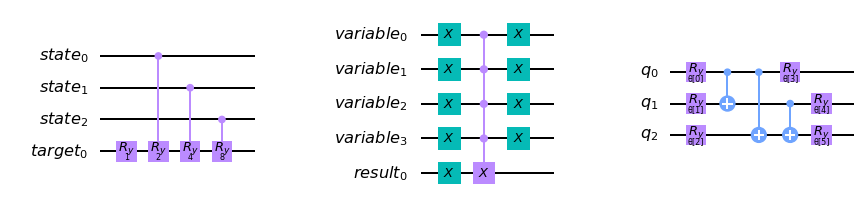

In [52]:
from qiskit.circuit.library import LinearPauliRotations, OR, RealAmplitudes

pauli_rots = LinearPauliRotations(3, offset=1, slope=2)
or_circuit = OR(4)
wavefunction = RealAmplitudes(3, reps=1)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=3)
pauli_rots.draw(output='mpl', ax=ax[0])
or_circuit.draw(output='mpl', scale=1.2, ax=ax[1])
wavefunction.draw(output='mpl', scale=1.6, ax=ax[2])

### These objects are circuits!

In [53]:
from qiskit.circuit.library import QFT
qft = QFT(3)

In [47]:
from qiskit import QuantumCircuit
isinstance(qft, QuantumCircuit)

True

In [48]:
print('Operations:')
print(qft.count_ops())
print()
print('QASM:') 
print(qft.qasm())

Operations:
OrderedDict([('h', 3), ('cu1', 3), ('swap', 1)])

QASM:
OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
h q[0];
cu1(pi/2) q[0],q[1];
cu1(pi/4) q[0],q[2];
h q[1];
cu1(pi/2) q[1],q[2];
h q[2];
swap q[0],q[2];



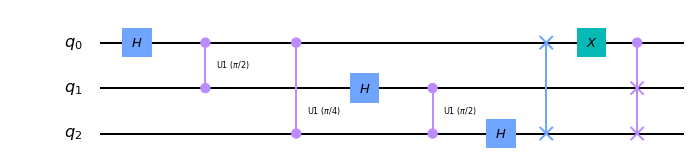

In [49]:
qft.x(0)
qft.cswap(0, 1, 2)
qft.draw(output='mpl')

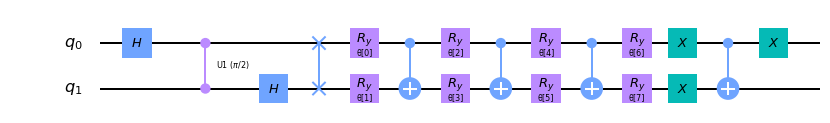

In [62]:
my_circuit = QFT(2).compose(RealAmplitudes(2)).compose(OR(1))
my_circuit.draw(output='mpl')

### But have additional functionality

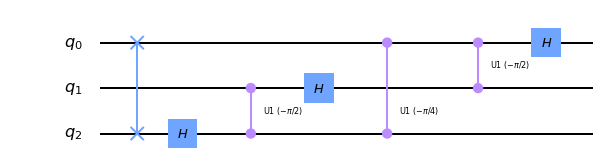

In [50]:
qft = QFT(3)
qft.inverse().draw(output='mpl')

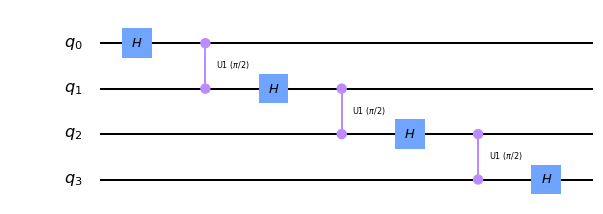

In [3]:
QFT(4, do_swaps=False, approximation_degree=2).draw(output='mpl')

![img](./algorithm_flow.png)

### What do we need for that? 

Circuits as first-class citizens in Aqua.

## Example: Variational Quantum Eigensolver 

In [101]:
from qiskit import Aer
from qiskit.aqua.operators import I, X, Z
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import COBYLA

h2_hamiltonian = -1.05 * (I ^ I) + 0.39 * (I ^ Z) - 0.39 * (Z ^ I) - 0.01 * (Z ^ Z) + 0.18 * (X ^ X)
h2_energy = -1.85727503

optimizer = COBYLA(maxiter=100)
backend = Aer.get_backend('statevector_simulator')

vqe = VQE(operator=h2_hamiltonian, optimizer=optimizer, quantum_instance=backend)

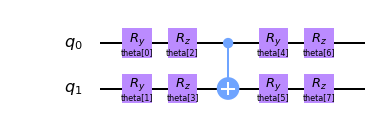

In [102]:
from qiskit.circuit import QuantumCircuit, ParameterVector

wavefunction = QuantumCircuit(2)
params = ParameterVector('theta', length=8)
it = iter(params)
wavefunction.ry(next(it), 0)
wavefunction.ry(next(it), 1)
wavefunction.rz(next(it), 0)
wavefunction.rz(next(it), 1)
wavefunction.cx(0, 1)
wavefunction.ry(next(it), 0)
wavefunction.ry(next(it), 1)
wavefunction.rz(next(it), 0)
wavefunction.rz(next(it), 1)

wavefunction.draw(output='mpl')

In [103]:
vqe.var_form = wavefunction
result = vqe.compute_minimum_eigenvalue()
print('VQE:', result.eigenvalue.real, 'Reference:', h2_energy)

VQE: -1.82277488314184 Reference: -1.85727503


Or just use the circuit library

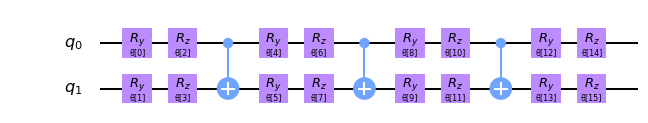

In [90]:
from qiskit.circuit.library import EfficientSU2
wavefunction = EfficientSU2(2, reps=3)
wavefunction.draw(output='mpl')

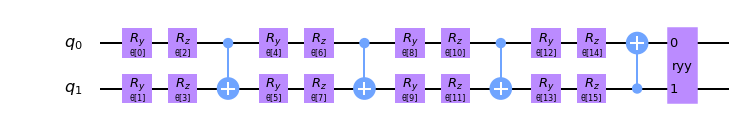

In [91]:
from qiskit.circuit import Parameter
wavefunction.cx(1, 0)
wavefunction.ryy(Parameter('theta'), 0, 1)

wavefunction.draw(output='mpl')

In [104]:
wavefunction.parameters

{Parameter(theta[0]),
 Parameter(theta[1]),
 Parameter(theta[2]),
 Parameter(theta[3]),
 Parameter(theta[4]),
 Parameter(theta[5]),
 Parameter(theta[6]),
 Parameter(theta[7])}

In [98]:
vqe = VQE(h2_hamiltonian, wavefunction, optimizer=optimizer, quantum_instance=backend)
result = vqe.compute_minimum_eigenvalue()
print('VQE:', result.eigenvalue.real, 'Reference:', h2_energy)

VQE: -1.84005413778857 Reference: -1.85727503


## Example: Quantum SVM (just for display, not talking)

In [107]:
import numpy as np
training_data = {'A': np.array([[2.95309709, 2.51327412],
                                [3.14159265, 4.08407045]]),
                 'B': np.array([[4.08407045, 2.26194671],
                                [4.46106157, 2.38761042]])}
testing_data = {'A': np.array([[3.83274304, 2.45044227]]),
                'B': np.array([[3.89557489, 0.31415927]])}

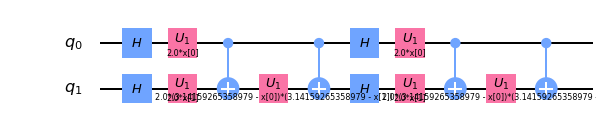

In [110]:
from qiskit.circuit.library import ZZFeatureMap
ZZFeatureMap(2).draw(output='mpl')

In [176]:
import os
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'
from qiskit.aqua.algorithms import QSVM

data_preparation = ZZFeatureMap(2)
qsvm = QSVM(data_preparation, training_data, testing_data, 
            quantum_instance=Aer.get_backend('statevector_simulator'))
result = qsvm.run()
print(result['svm']['support_vectors'])

[[2.95309709 2.51327412]
 [3.14159265 4.08407045]
 [4.08407045 2.26194671]
 [4.46106157 2.38761042]]


### But... didn't we already have this before in Aqua?

The `VariationalForm` objects offered some trial wavefunctions as wrapped circuits.

Problems:
* parallel implementation to Terra
* additional objects to learn
* new class for every new wavefunction!

### The 2-local circuits

In [ ]:
# before
class H_RX_CZ(VariationalForm):
    def __init__(self, num_qubits, depth=3, entangler_map=None, entanglement='full', initial_state=None,
                 skip_unentangled_qubits=False):
        super().__init__()
        self._num_qubits = num_qubits
        self._depth = depth
        self._entanglement = entanglement

        if entangler_map is None:
            self._entangler_map = VariationalForm.get_entangler_map(entanglement, num_qubits)
        else:
            self._entangler_map = VariationalForm.validate_entangler_map(entangler_map, num_qubits)

        # determine the entangled qubits
        all_qubits = []
        for src, targ in self._entangler_map:
            all_qubits.extend([src, targ])
        self._entangled_qubits = sorted(list(set(all_qubits)))
        self._initial_state = initial_state
        self._entanglement_gate = entanglement_gate
        self._skip_unentangled_qubits = skip_unentangled_qubits
        self._skip_final_ry = skip_final_ry

        self._num_parameters = len(self._entangled_qubits) * (depth + 1)
        self._bounds = [(-np.pi, np.pi)] * self._num_parameters

    def construct_circuit(self, parameters, q=None):
        if len(parameters) != self._num_parameters:
            raise ValueError('The number of parameters has to be {}'.format(self._num_parameters))

        if q is None:
            q = QuantumRegister(self._num_qubits, name='q')
        if self._initial_state is not None:
            circuit = self._initial_state.construct_circuit('circuit', q)
        else:
            circuit = QuantumCircuit(q)

        param_idx = 0
        for qubit in range(self._num_qubits):
            if not self._skip_unentangled_qubits or qubit in self._entangled_qubits:
                circuit.h(q[qubit])
                circuit.rx(parameters[param_idx], q[qubit])  # ry
                param_idx += 1

        for block in range(self._depth):
            for src, targ in self._entangler_map:
                circuit.cz(q[src], q[targ])
                
        return circuit
    
h_rx_cz = H_RX_CZ(num_qubits=4)

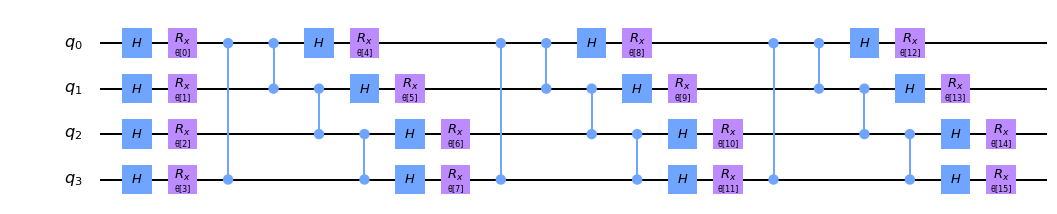

In [80]:
# now
from qiskit.circuit.library import TwoLocal
h_rx_cz = TwoLocal(4, ['h', 'rx'], 'cz', entanglement='circular')
h_rx_cz.draw(output='mpl')

Modifications needed? No problem, this is a circuit you can do whatever you want!  

### Gimmicks / Mutability / Pattern (missing good title)

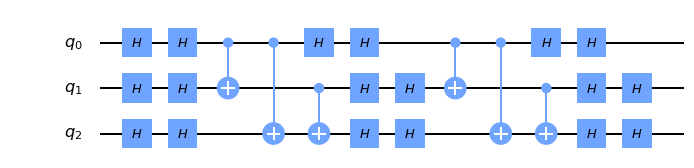

In [113]:
ansatz = TwoLocal(3, 'rz', 'cx', reps=1)
ansatz.rotation_blocks = ['h', 'h']
ansatz.reps = 2
ansatz.draw(output='mpl')

It's a pattern! 

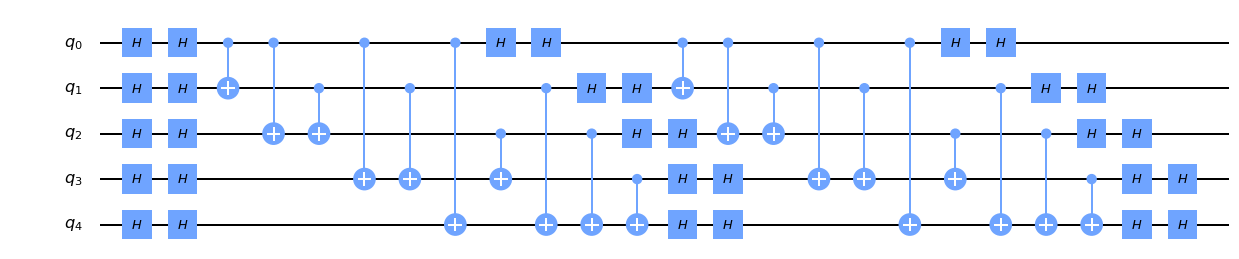

In [114]:
ansatz.num_qubits = 5
ansatz.draw(output='mpl')

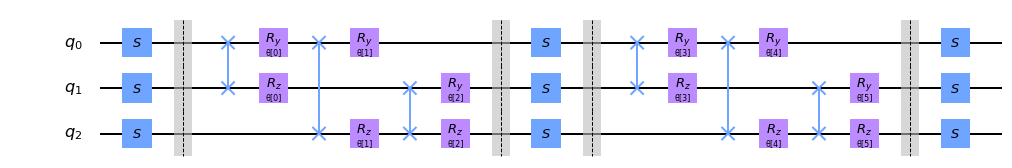

In [83]:
from qiskit.circuit import Parameter
from qiskit.circuit.library import SGate
theta = Parameter('theta')
block = QuantumCircuit(2)
block.swap(0, 1)
block.ry(theta, 0)
block.rz(theta, 1)

ansatz = TwoLocal(3, SGate(), block, reps=2, insert_barriers=True)
ansatz.draw(output='mpl')

Generalization: N-local circuit

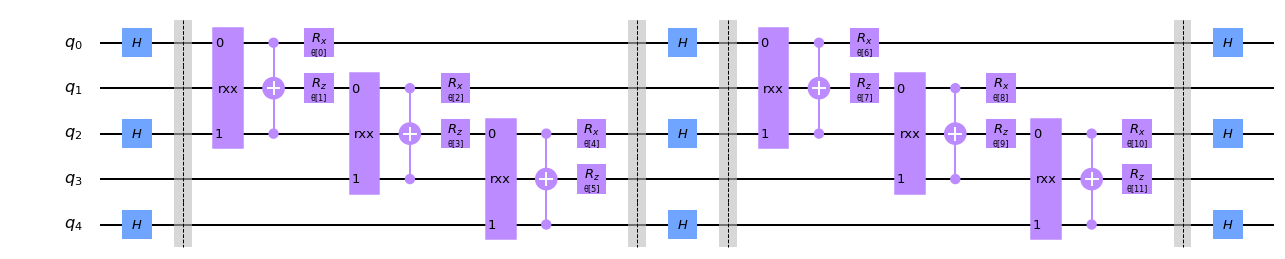

In [86]:
from qiskit.circuit.library import NLocal
theta, phi = Parameter('theta'), Parameter('phi')
block = QuantumCircuit(3)
block.rxx(theta, 0, 2)
block.ccx(0, 2, 1)
block.rx(theta, 0)
block.rz(phi, 1)
intermediate = QuantumCircuit(5)
intermediate.h([0, 2, 4])
ansatz = NLocal(5, intermediate, block, entanglement='linear', 
                reps=2, insert_barriers=True)
ansatz.draw(output='mpl')

### Mutability in action

In [ ]:
h2_hamiltonian = -1.05 * (I ^ I) + 0.39 * (I ^ Z) - 0.39 * (Z ^ I) - 0.01 * (Z ^ Z) + 0.18 * (X ^ X)
h2_energy = -1.85727503

optimizer = COBYLA(maxiter=100)
backend = Aer.get_backend('statevector_simulator')

wavefunction = EfficientSU2()  # no number of qubits specified!

vqe = VQE(h2_hamiltonian, wavefunction, optimizer=optimizer, quantum_instance=backend)
result = vqe.run()
print(result.eigenvalue.real)

![img](./mutability.png)

In [118]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.algorithms import MinimumEigenOptimizer

In [132]:
wavefunction = RealAmplitudes(entanglement='circular')
vqe = VQE(var_form=wavefunction, optimizer=COBYLA(maxiter=100), 
          quantum_instance=Aer.get_backend('statevector_simulator'))
min_eigen_optimizer = MinimumEigenOptimizer(vqe)

In [164]:
problem1 = QuadraticProgram()
num_variables = 2
for _ in range(num_variables):
    problem1.binary_var()
problem1.objective.linear = [1, 2]
problem1.objective.quadratic = [[2, 0], [0, -1]]
problem1.linear_constraint([1, 1], '==', 1)

min_eigen_optimizer.solve(problem1)

([0.0,1.0] / 1.0 / OptimizationResultStatus.SUCCESS)

In [165]:
print('Number of qubits:', min_eigen_optimizer._min_eigen_solver._var_form.num_qubits)

Number of qubits: 2


In [161]:
problem2 = QuadraticProgram()
num_variables = 4
for _ in range(num_variables):
    problem2.binary_var()
problem2.objective.linear = [1, 2, 0, 1]
problem2.objective.quadratic = [[-1, 0, 0, 1], [0, -1, 0, 0], [0, 0, 3, 0], [1, 0, 0, 2]]
problem2.linear_constraint([1, 1, 1, 1], '==', 2)

min_eigen_optimizer.solve(problem1)

([1.0,1.0,0.0,0.0] / 1.0 / OptimizationResultStatus.SUCCESS)

In [162]:
print('Number of qubits:', min_eigen_optimizer._min_eigen_solver._var_form.num_qubits)

Number of qubits: 4


![img](./what_moved.png)